<a href="https://colab.research.google.com/github/alopezmontes/organoid_segmentation/blob/main/Segment_organoids.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Simple code for analyzing images

#installing necessary packages
!pip install matplotlib
!pip install pillow
!pip install scipy
!pip install scikit-image
!pip install ipympl
!pip install opencv-python
!pip install xlsxwriter
!pip install glob2

In [ ]:
# importing the packages you will need during the execution
import sys
import numpy as np
import matplotlib
import os
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageFilter
import scipy.io as sio
from scipy import ndimage
from scipy.ndimage import gaussian_filter
from scipy import stats as st
import skimage
from skimage import measure
from skimage.segmentation import slic
from skimage.color import label2rgb
from skimage.segmentation import felzenszwalb
import xlsxwriter
import glob
from matplotlib import figure


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import output
output.enable_custom_widget_manager()
output.disable_custom_widget_manager()

Mounted at /content/drive


In [ ]:
# moving to the folder with the organoids
os.chdir('/content/drive/MyDrive/2023_cz031_organoids size')
#see what is in the folder
cases_dir = os.listdir()
print(cases_dir)

['cz031_70351', 'cz031_ogtt104', 'cz031_sjh005', 'cz031_70310', 'cz031_40090', 'cz031_srp012']


In [ ]:
# moving to the folder with the organoids
os.chdir('/content/drive/MyDrive/2023_cz031_organoids size')
#see what is in the folder
cases_dir = os.listdir()
print(cases_dir)

#loop to go through all the folders
#for icase in range(0,np.size(cases_dir)):
plt.close('all')
from google.colab import output
output.enable_custom_widget_manager()

for icase in range (0,np.size(cases_dir)):
  wkdir = cases_dir[icase]
  print(wkdir)
  os.chdir(wkdir)
  org_imgs=[]
  for file in os.listdir():
    if file.endswith(".jpg"):
      org_imgs.append(file)
  #for iorg in range(0,np.size(org_imgs)):
  workbook = xlsxwriter.Workbook('results/Results_segmentation'+wkdir+'.xlsx') #opening an excel sheet to write the results
  worksheet = workbook.add_worksheet() #adding a worksheet
  worksheet.write(0, 0, 'File name')
  worksheet.write(0, 1, 'Area (pixels)')
  worksheet.write(0, 2, 'Original image')
  worksheet.write(0, 3, 'Masked image')
  worksheet.set_default_row(40)
  worksheet.set_column(0, 100)  # Set the height of Row 1 to 20.
  worksheet.set_column(1, 100)  # Set the height of Row 1 to 20.

  # Start from the first cell.
  # Rows and columns are zero indexed.
  ikk = 0
  names_dir = []
  area_tot = []
  for iorg in range(0,np.size(org_imgs)):
    wimg = org_imgs[iorg]
    names_dir.append(wimg)
    print(names_dir[ikk])
    img = cv2.imread(wimg)
    img_array =np.array(img)
    img0 = img_array
    img0_g =  np.mean(img0, -1)
    img_array=img0_g;
    img_array = np.multiply(img0_g,1)
    img_array[img_array>90] = 90 #set values higher than the threshold as background. Manual threshold for the moment
    img_array = img_array/90
    img_array = 1- img_array
    segment = felzenszwalb(img_array,scale = 200,sigma=6,min_size=3)
    kk = st.mode(segment[img0_g<70],axis=None,keepdims=False)
    mask = np.zeros_like(segment)
    mask[segment==kk.mode] = 1
    kernel = np.ones((5, 5), np.uint8)
    #mask = ndimage.grey_erosion(mask,size=20)
    #mask = ndimage.grey_dilation(mask,size=20)
    mask = ndimage.grey_dilation(mask,size=20)
    mask = ndimage.grey_erosion(mask,size=20)
    mask[mask>0] = 1.0
    grad2d = np.gradient(mask)
    gradm = np.power(np.power(grad2d[0][:][:],2)+ np.power(grad2d[1][:][:],2),0.5)
    print(np.max(gradm,axis=None))
    perimeter_mask = 1.0*np.sum(gradm,axis=None)
    print(perimeter_mask)
    #%matplotlib widget
    #figure,
    #plt.subplot(1,2,1)
    #plt.imshow(np.multiply(mask,1),cmap='gray',vmin = 0, vmax = 1)
    #plt.subplot(1,2,2)
    #plt.imshow(gradm,cmap='gray',vmin = 0, vmax = 1)
    masked = np.multiply(mask,img0_g)
    masked_img = Image.fromarray(masked)
    edge_img = Image.fromarray(255*gradm)
    if masked_img.mode != 'RGB':
      masked_img = masked_img.convert('RGB')
    if edge_img.mode != 'RGB':
      edge_img = edge_img.convert('RGB')
    output_img = 'results/Masked_'+wimg
    output_img2 = 'results/Edges_'+wimg
    masked_img.save(output_img)
    edge_img.save(output_img2)
    area_mask = 1.0*np.sum(mask,axis=None)
    area_tot.append(area_mask)
    #print(np.shape(mask))
    #print(np.shape(gradm))
    circularity_mask = 4*np.pi*area_mask/(perimeter_mask*perimeter_mask)
    print("Total area (in pixels) %i" % area_tot[ikk])
    print("Total perimeter (in pixels) %i" % perimeter_mask)
    ikk = ikk + 1
    print("Circularity %6.3f" % circularity_mask)
    worksheet.write(ikk, 0, wimg)
    worksheet.write(ikk, 1, area_mask)
    worksheet.write(ikk, 2, perimeter_mask)
    worksheet.write(ikk, 3, circularity_mask)
    worksheet.insert_image(ikk, 4,wimg,{"x_scale": 0.05, "y_scale": 0.05})
    worksheet.insert_image(ikk, 5,output_img,{"x_scale": 0.05, "y_scale": 0.05})
    worksheet.insert_image(ikk, 6,output_img2,{"x_scale": 0.05, "y_scale": 0.05})

  workbook.close()
  os.chdir('/content/drive/MyDrive/2023_cz031_organoids size')

In [ ]:
%matplotlib widget
figure
plt.subplot(1,2,1)
plt.imshow(np.multiply(mask,img0_g),cmap='gray',vmin = 0, vmax = 255)
plt.subplot(1,2,2)
plt.imshow(img0_g,cmap='gray',vmin = 0, vmax = 255)

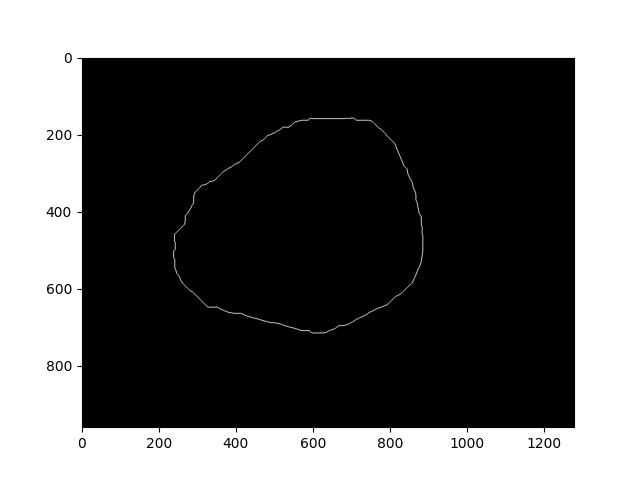

In [ ]:
plt.close('all')

grad2d = np.gradient(mask)
gradm = np.power(np.power(grad2d[0][:][:],2)+ np.power(grad2d[1][:][:],2),0.5)
gradm[gradm>0]=1
%matplotlib widget
figure,
plt.imshow(gradm,cmap='gray')